# MGL869 - Lab

*MGL869 ETS Montreal - Production engineering*

## Abstract

## Authors
- **Léo FORNOFF**
- **William PHAN**
- **Yannis OUAKRIM**

---

## Part 1 : Data collection

In [1]:
from Jira import jira_download
from pandas import Index
from numpy import ndarray


### 1.1 - Download Jira data
We download data if they are not already present in the data folder.

Return the dataframe of the data.

Query filter can be defined in config.ini

In [2]:
jira_dataframe = jira_download()

Data already downloaded
Filter = 'project=HIVE AND issuetype=Bug AND status in (Resolved, Closed) AND affectedVersion>= 2.0.0'


### 1.2 - Clean Jira data using pandas
Previously, we downloaded all the data from Jira. Now, we will clean the data using pandas.
We will keep only some columns and combine some columns.

In [3]:
keep: [str] = ['Issue key', 'Status', 'Resolution', 'Created', 'Fix Versions Combined', 'Affects Versions Combined']

In [4]:
affects_version_columns: [str] = [col for col in jira_dataframe.columns if col.startswith('Affects Version/s')]
jira_dataframe['Affects Versions Combined'] = jira_dataframe[affects_version_columns].apply(
    lambda x: ', '.join(x.dropna().astype(str)), axis=1
)

In [5]:
# Combine the versions into a single column
fix_version_columns: [str] = [col for col in jira_dataframe.columns if col.startswith('Fix Version/s')]

jira_dataframe['Fix Versions Combined'] = jira_dataframe[fix_version_columns].apply(
    lambda x: ', '.join(x.dropna().astype(str)), axis=1
)
jira_dataframe = jira_dataframe.loc[:, keep]

In [6]:
# Identify columns whose names contain the string 'Issue key'
issue_key_columns: Index = jira_dataframe.columns[jira_dataframe.columns.str.contains('Issue key')]
# Extract the values from these columns as a NumPy array
issue_key_values: ndarray = jira_dataframe[issue_key_columns].values
# Flatten the array to create a one-dimensional list of all 'Issue key' values
flattened_issue_keys: ndarray = issue_key_values.flatten()
# Convert the list into a set to remove duplicates
ids: set = set(flattened_issue_keys)

---


## Part 2 : Repository analysis


In [7]:
from Hive import git_download, commit_analysis, update_commit_dataframe
from git import Repo, Tag
from pandas import DataFrame
from configparser import ConfigParser
from re import compile
from packaging import version

### 2.1 - Clone repository

In [8]:
repo: Repo = git_download()

data\hive_data\hiveRepo False
Pulling the repository: https://github.com/apache/hive.git
Pull failed :  Cmd('git') failed due to: exit code(1)
  cmdline: git pull -v -- origin


In [9]:
all_couples = commit_analysis(ids)

20493 couples found.


### 2.2 - Filter data

In [10]:
commit_dataframe: DataFrame = DataFrame(all_couples, columns=["Issue key", "File", "Commit"])

In [11]:
# Languages without whitespaces
config: ConfigParser = ConfigParser()
config.read("config.ini")
languages: [str] = config["GENERAL"]["Languages"].split(",")
languages: [str] = [lang.strip() for lang in languages]
commit_dataframe: DataFrame = commit_dataframe[commit_dataframe['File'].str.endswith(tuple(languages))]

In [12]:
couples = update_commit_dataframe(commit_dataframe, jira_dataframe)
couples

,Issue key,File,Version Affected
0,HIVE-28239,standalone-metastore/metastore-server/src/main...,4.0.0
1,HIVE-28239,standalone-metastore/metastore-server/src/test...,4.0.0
2,HIVE-28217,jdbc/src/java/org/apache/hive/jdbc/Utils.java,3.1.2
3,HIVE-28217,jdbc/src/test/org/apache/hive/jdbc/TestHiveCon...,3.1.2
4,HIVE-28262,serde/src/java/org/apache/hadoop/hive/serde2/l...,"3.1.3, 4.1.0"
...,...,...,...
10236,HIVE-13932,ql/src/java/org/apache/hadoop/hive/ql/exec/SMB...,"1.0.0, 2.0.0"
10237,HIVE-13904,ql/src/java/org/apache/hadoop/hive/ql/parse/QB...,"2.0.1, 2.1.0, 2.2.0"
10238,HIVE-13599,llap-server/src/java/org/apache/hadoop/hive/ll...,2.1.0
10239,HIVE-13599,llap-server/src/test/org/apache/hadoop/hive/ll...,2.1.0


### 2.3 - Extract filter versions from git

In [13]:
releases_regex: [str] = config["GIT"]["ReleasesRegex"].split(",")
tags: Tag = repo.tags
versions: dict = {tag.name: tag.commit for tag in tags}
releases_regex: [str] = [regex.strip() for regex in releases_regex]
releases_regex = [compile(regex) for regex in releases_regex]

In [14]:
filtered_versions: dict = {}
for version_str in versions:
    if any(regex.match(version_str) for regex in releases_regex):
        version_numbers = version_str.split("-")[1]
        if version.parse(version_numbers) >= version.parse("2.0"):
            filtered_versions[version_numbers] = versions[version_str]

filtered_versions = dict(sorted(
    filtered_versions.items(),
    key=lambda item: item[1].committed_datetime,
    reverse=True
))

filtered_versions, len(filtered_versions)

({'4.0.1': <git.Commit "3af4517eb8cfd9407ad34ed78a0b48b57dfaa264">,
  '2.3.10': <git.Commit "5160d3af392248255f68e41e1e0557eae4d95273">,
  '4.0.0': <git.Commit "183f8cb41d3dbed961ffd27999876468ff06690c">,
  '3.1.3': <git.Commit "4df4d75bf1e16fe0af75aad0b4179c34c07fc975">,
  '2.3.9': <git.Commit "92dd0159f440ca7863be3232f3a683a510a62b9d">,
  '2.3.8': <git.Commit "f1e87137034e4ecbe39a859d4ef44319800016d7">,
  '2.3.7': <git.Commit "cb213d88304034393d68cc31a95be24f5aac62b6">,
  '3.1.2': <git.Commit "8190d2be7b7165effa62bd21b7d60ef81fb0e4af">,
  '2.3.6': <git.Commit "2c2fdd524e8783f6e1f3ef15281cc2d5ed08728f">,
  '2.3.5': <git.Commit "76595628ae13b95162e77bba365fe4d2c60b3f29">,
  '2.3.4': <git.Commit "56acdd2120b9ce6790185c679223b8b5e884aaf2">,
  '3.1.1': <git.Commit "f4e0529634b6231a0072295da48af466cf2f10b7">,
  '3.1.0': <git.Commit "bcc7df95824831a8d2f1524e4048dfc23ab98c19">,
  '3.0.0': <git.Commit "ce61711a5fa54ab34fc74d86d521ecaeea6b072a">,
  '2.3.3': <git.Commit "3f7dde31aed44b5440563d3

## Part 3. - Understand analysis

In [15]:
from Understand.commands import und_create_command, und_purge_command
from Understand.metrics import metrics
from Understand.label import label_all_metrics
from Understand.enrich import enrich_metrics
from Understand.update import merge_all_metrics
from os import path

### 3.1 - Create the Understand project


In [16]:
hive_git_directory: str = config["GIT"]["HiveGitDirectory"]
data_directory: str = config["GENERAL"]["DataDirectory"]
understand_project_name: str = config["UNDERSTAND"]["UnderstandProjectName"]

understand_project_path: str = path.join(data_directory, hive_git_directory, understand_project_name)

if not path.exists(understand_project_path):
    und_create_command()

In [17]:
und_purge_command()

Running command : 
     und purge -db data\hive_data\hive.und
Database purged.



### 3.2 - Metrics extraction


In [18]:
metrics(filtered_versions)

Metrics analysis is skipped as per configuration.


### 3.3 - Labeling


In [19]:
label_all_metrics(couples)

Processing metrics file: data\metrics_output\2.0.0_metrics.csv
Labeled metrics saved to: data\labeled_metrics_output\2.0.0_labeled_metrics.csv
Processing metrics file: data\metrics_output\2.0.1_metrics.csv
Labeled metrics saved to: data\labeled_metrics_output\2.0.1_labeled_metrics.csv
Processing metrics file: data\metrics_output\2.1.0_metrics.csv
Labeled metrics saved to: data\labeled_metrics_output\2.1.0_labeled_metrics.csv
Processing metrics file: data\metrics_output\2.1.1_metrics.csv
Labeled metrics saved to: data\labeled_metrics_output\2.1.1_labeled_metrics.csv
Processing metrics file: data\metrics_output\2.2.0_metrics.csv
Labeled metrics saved to: data\labeled_metrics_output\2.2.0_labeled_metrics.csv
Processing metrics file: data\metrics_output\2.3.0_metrics.csv
Labeled metrics saved to: data\labeled_metrics_output\2.3.0_labeled_metrics.csv
Processing metrics file: data\metrics_output\2.3.10_metrics.csv
Labeled metrics saved to: data\labeled_metrics_output\2.3.10_labeled_metrics.c

In [20]:
enrich_metrics(couples)

Processing enrichment metrics file: data\metrics_output\2.0.0_metrics.csv
Enriched metrics saved to: data\labeled_metrics_output\2.0.0_enrichi_metrics.csv
Processing enrichment metrics file: data\metrics_output\2.0.1_metrics.csv
Enriched metrics saved to: data\labeled_metrics_output\2.0.1_enrichi_metrics.csv
Processing enrichment metrics file: data\metrics_output\2.1.0_metrics.csv
Enriched metrics saved to: data\labeled_metrics_output\2.1.0_enrichi_metrics.csv
Processing enrichment metrics file: data\metrics_output\2.1.1_metrics.csv
Enriched metrics saved to: data\labeled_metrics_output\2.1.1_enrichi_metrics.csv
Processing enrichment metrics file: data\metrics_output\2.2.0_metrics.csv
Enriched metrics saved to: data\labeled_metrics_output\2.2.0_enrichi_metrics.csv
Processing enrichment metrics file: data\metrics_output\2.3.0_metrics.csv
Enriched metrics saved to: data\labeled_metrics_output\2.3.0_enrichi_metrics.csv
Processing enrichment metrics file: data\metrics_output\2.3.10_metrics

In [21]:
v = [
    "2.0.0", "2.0.1", "2.1.0", "2.1.1", "2.2.0", "2.3.0", "2.3.1", "2.3.2",
    "2.3.3", "2.3.4", "2.3.5", "2.3.6", "2.3.7", "2.3.8", "2.3.9", "2.3.10",
    "3.0.0", "3.1.0", "3.1.1", "3.1.2", "3.1.3", "4.0.0", "4.0.1"
]
merge_all_metrics(v)

Final file generated for version 2.0.0: data\labeled_metrics_output\2.0.0_static_metrics.csv
Final file generated for version 2.0.1: data\labeled_metrics_output\2.0.1_static_metrics.csv
Final file generated for version 2.1.0: data\labeled_metrics_output\2.1.0_static_metrics.csv
Final file generated for version 2.1.1: data\labeled_metrics_output\2.1.1_static_metrics.csv
Final file generated for version 2.2.0: data\labeled_metrics_output\2.2.0_static_metrics.csv
Final file generated for version 2.3.0: data\labeled_metrics_output\2.3.0_static_metrics.csv
Final file generated for version 2.3.1: data\labeled_metrics_output\2.3.1_static_metrics.csv
Final file generated for version 2.3.2: data\labeled_metrics_output\2.3.2_static_metrics.csv
Final file generated for version 2.3.3: data\labeled_metrics_output\2.3.3_static_metrics.csv
Final file generated for version 2.3.4: data\labeled_metrics_output\2.3.4_static_metrics.csv
Final file generated for version 2.3.5: data\labeled_metrics_output\2.

---

---

## 4 - Model

In [22]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from configparser import ConfigParser

from IA_models import load_data, KFold_XY, plot_SHAP, plot_AUC, \
    plot_recall, plot_precision, generate_model_report

---

### 4.1 - Pipeline Learning Model
#### 4.1.1 - Load data

In [23]:
config: ConfigParser = ConfigParser()
config.read("config.ini")

DATA_DIRECTORY: str = config["GENERAL"]["DataDirectory"]
LABELED_METRICS_OUTPUT_DIRECTORY: str = os.path.join(DATA_DIRECTORY, config["OUTPUT"]["LabeledMetricsOutputDirectory"])
N_SPLITS: int = int(config["IA"]["NSplits"])
SHUFFLE: bool = config["IA"].getboolean("Shuffle")
RANDOM_STATE: int = int(config["IA"]["RandomState"])
N_ESTIMATORS: int = int(config["IA"]["nEstimators"])

data_dict: dict = load_data(LABELED_METRICS_OUTPUT_DIRECTORY)

#### 4.1.2 - Prepare data
The commit version, its ID, and the file name are not considered in the model training. All columns containing a NaN are unusable and removed.

In [24]:
XY_dict: dict = {}
for key in data_dict.keys():
    data: pd.DataFrame = data_dict[key]
    X = data.drop(columns=['BugStatus', 'Name']).dropna(axis=1)  # independent variables
    y = data['BugStatus']  # presence of a bug
    XY_dict[key] = (X, y)
XY_dict.keys()

dict_keys(['2.0.0_static_metrics.csv', '2.1.0_static_metrics.csv', '2.2.0_static_metrics.csv', '2.3.0_static_metrics.csv', '3.0.0_static_metrics.csv', '3.1.0_static_metrics.csv', '4.0.0_static_metrics.csv'])

#### 4.1.3 Training and test data
The entire dataset is divided into 10 equal parts on which the model is trained. Validation is performed [using cross-validation](https://medium.com/@tubelwj/five-methods-for-data-splitting-in-machine-learning-27baa50908ed) to more accurately determine the effectiveness of our model.

In [25]:
XY_training_dict: dict = {}
XY_testing_dict: dict = {}
for key in XY_dict.keys():
    X, y = XY_dict[key]
    X_train, X_test, y_train, y_test = KFold_XY(N_SPLITS, SHUFFLE, RANDOM_STATE, X, y)
    XY_training_dict[key] = (X_train, y_train)
    XY_testing_dict[key] = (X_test, y_test)

### 4.1.4 Model Training

Comparison between logistic regression and random forest.

In [26]:
logistic_regression_models: dict = {}
random_forest_models: dict = {}

for key in XY_training_dict:
    X_train, y_train = XY_training_dict[key]
    log_model = LogisticRegression(max_iter=20_000_000)
    random_model = RandomForestClassifier(n_estimators=N_ESTIMATORS, random_state=RANDOM_STATE)

    log_model.fit(X_train, y_train)
    random_model.fit(X_train, y_train)

    logistic_regression_models[key] = log_model
    random_forest_models[key] = random_model

C:\Users\moshi\Documents\projects\Informatique\ETS\MGL869\MGL869-Lab-Hive\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\moshi\Documents\projects\Informatique\ETS\MGL869\MGL869-Lab-Hive\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documenta

---

### 4.2 - Evaluation of the model performance
#### 4.2.1 Prediction

In [27]:
logistic_regression_predictions: dict = {}
random_forest_prediction: dict = {}

for key in XY_testing_dict:
    X_test, y_test = XY_testing_dict[key]
    random_forest_prediction[key] = random_forest_models[key].predict(X_test)
    logistic_regression_predictions[key] = logistic_regression_models[key].predict(X_test)

#### 4.2.2 Evaluation

The 2 models are compared by their AUC, precision, and recall. The **random forest** is a better model for determining the presence of bugs in a commit.

##### AUC

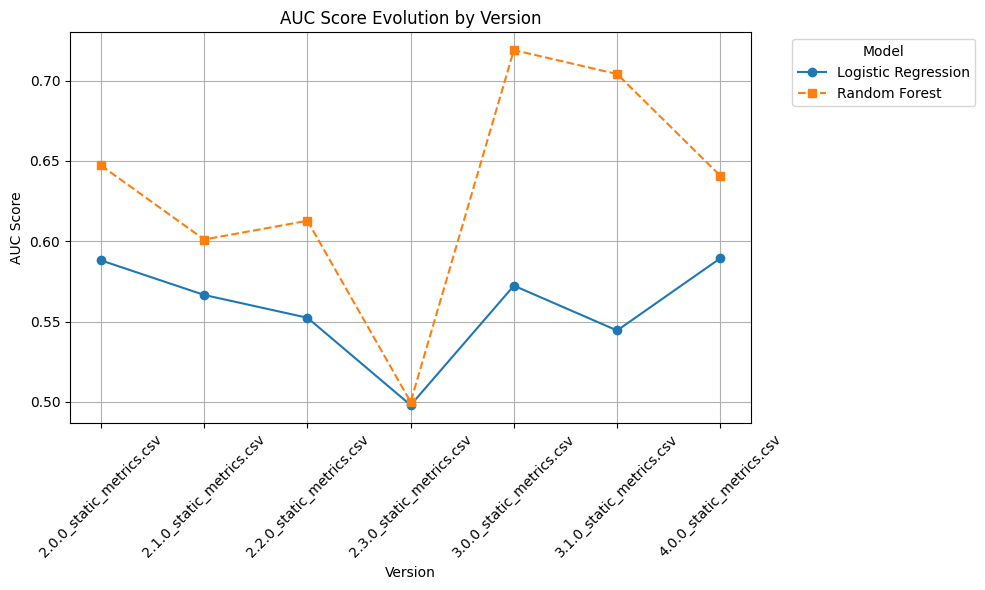

In [28]:
y_test: dict = {key: XY_testing_dict[key][1] for key in XY_testing_dict.keys()}
y_pred_log: dict = {key: logistic_regression_predictions[key] for key in logistic_regression_predictions.keys()}
y_pred_rf: dict = {key: random_forest_prediction[key] for key in random_forest_prediction.keys()}
plot_AUC(y_test, y_pred_log, y_pred_rf)

##### recall

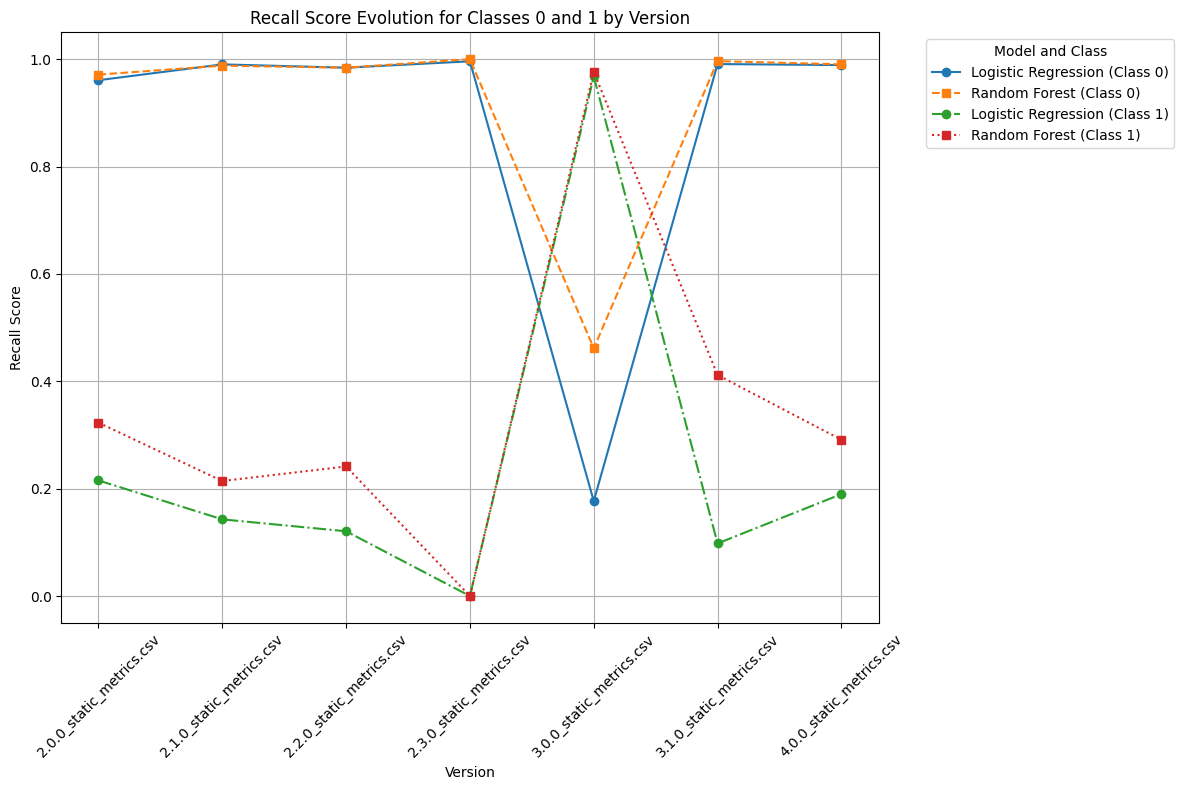

In [29]:
plot_recall(y_test, y_pred_log, y_pred_rf)

##### Precision

C:\Users\moshi\Documents\projects\Informatique\ETS\MGL869\MGL869-Lab-Hive\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


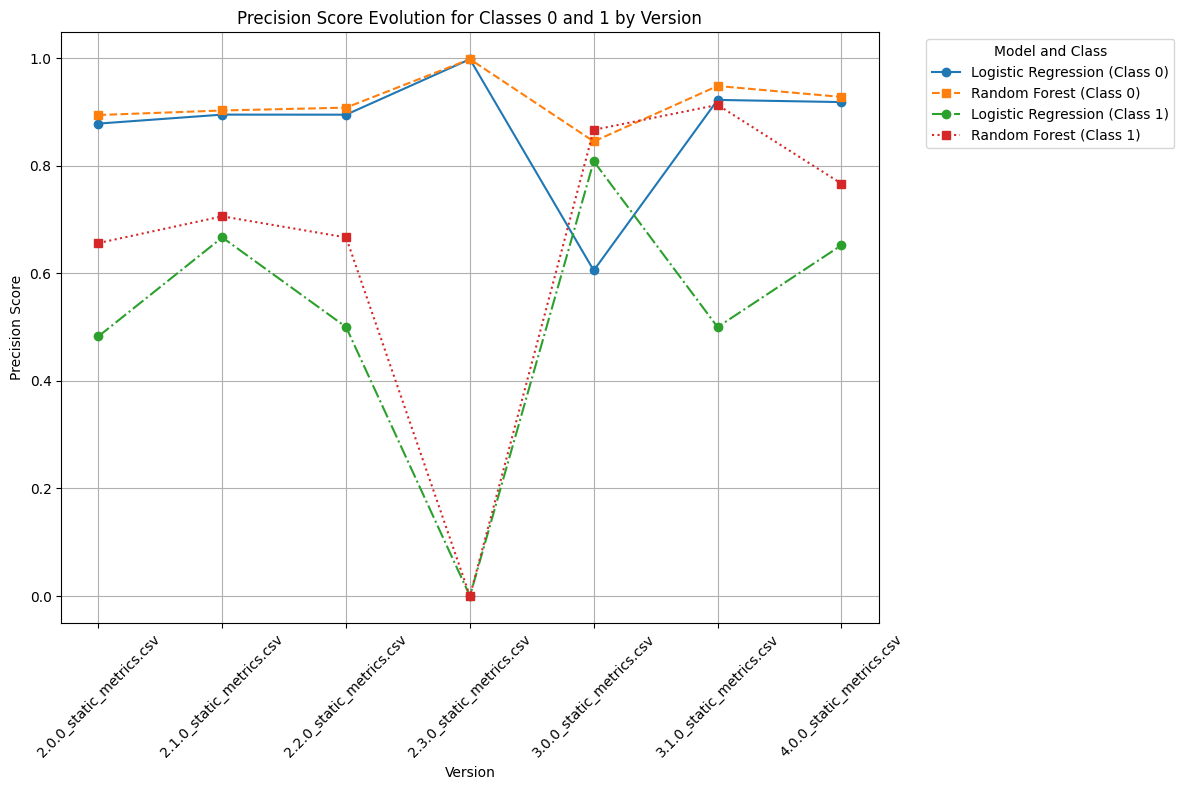

In [30]:
plot_precision(y_test, y_pred_log, y_pred_rf)

##### Report

In [31]:
generate_model_report(y_test, y_pred_log, y_pred_rf)

C:\Users\moshi\Documents\projects\Informatique\ETS\MGL869\MGL869-Lab-Hive\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,Version,Model,Precision 0,Precision 1,Recall 0,Recall 1
0,2.0.0_static_metrics.csv,Logistic Regression,0.878282,0.482759,0.960836,0.215385
1,2.0.0_static_metrics.csv,Random Forest,0.894231,0.656250,0.971279,0.323077
2,2.1.0_static_metrics.csv,Logistic Regression,0.894967,0.666667,0.990315,0.142857
3,2.1.0_static_metrics.csv,Random Forest,0.902655,0.705882,0.987893,0.214286
4,2.2.0_static_metrics.csv,Logistic Regression,0.894845,0.500000,0.984127,0.120690
5,2.2.0_static_metrics.csv,Random Forest,0.907950,0.666667,0.984127,0.241379
6,2.3.0_static_metrics.csv,Logistic Regression,0.998020,0.000000,0.996047,0.000000
7,2.3.0_static_metrics.csv,Random Forest,0.998028,0.000000,1.000000,0.000000
8,3.0.0_static_metrics.csv,Logistic Regression,0.605263,0.808244,0.176923,0.967811
9,3.0.0_static_metrics.csv,Random Forest,0.845070,0.866667,0.461538,0.976395


##### SHAP values

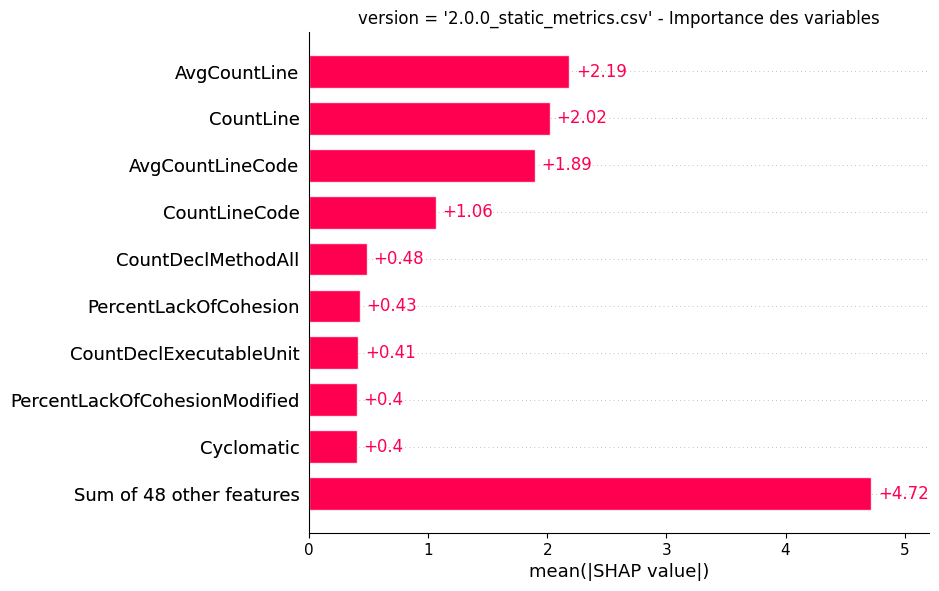

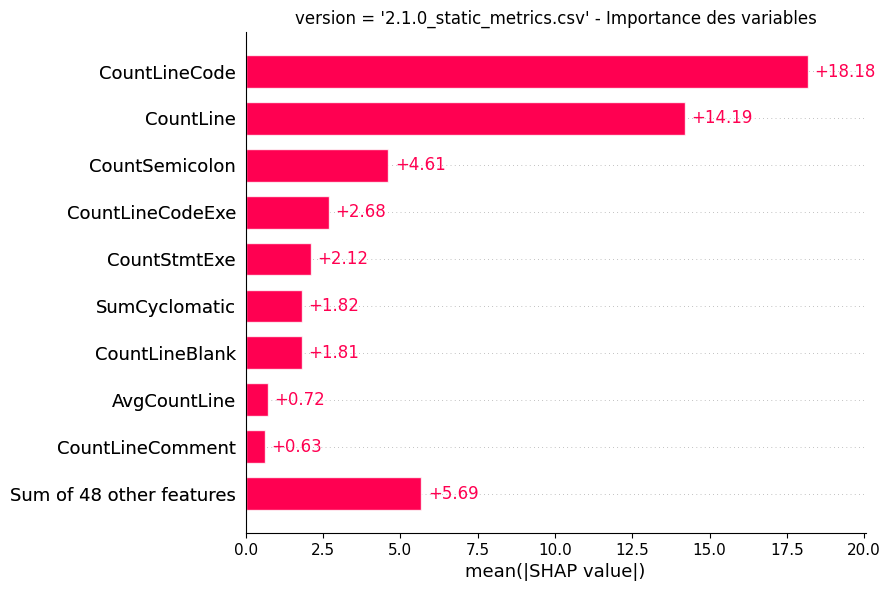

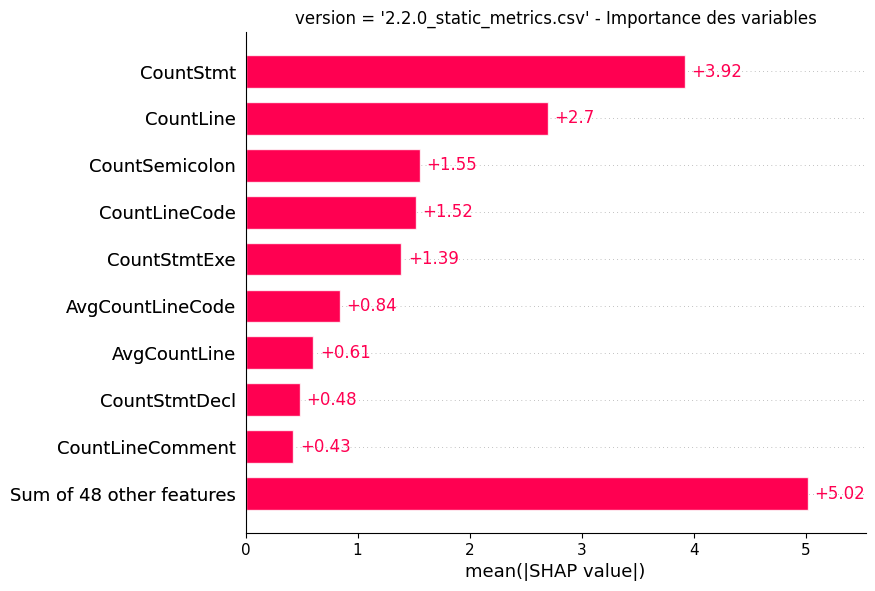

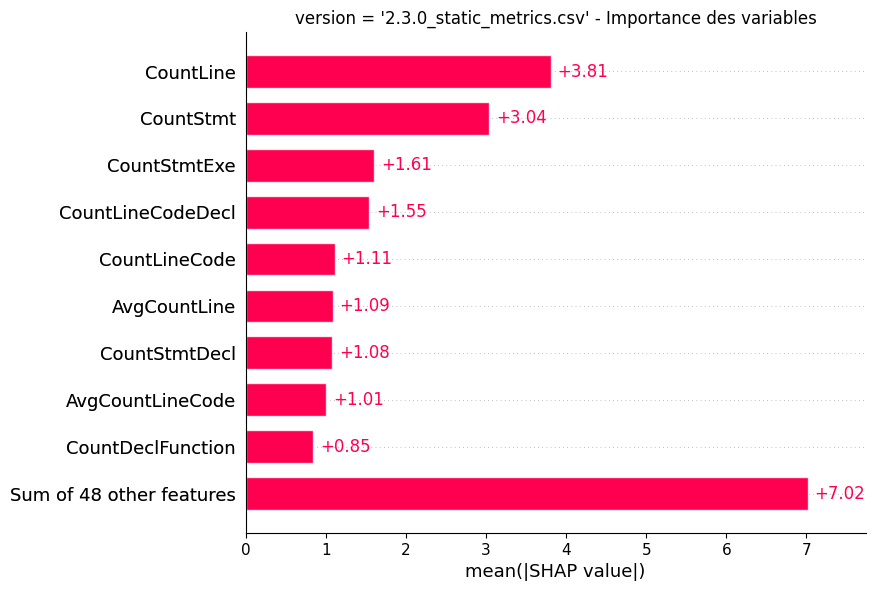

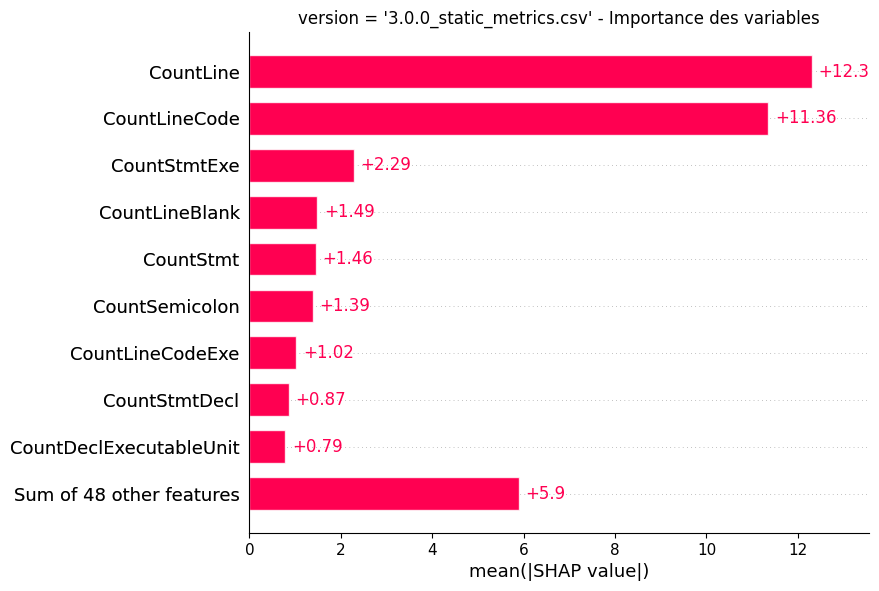

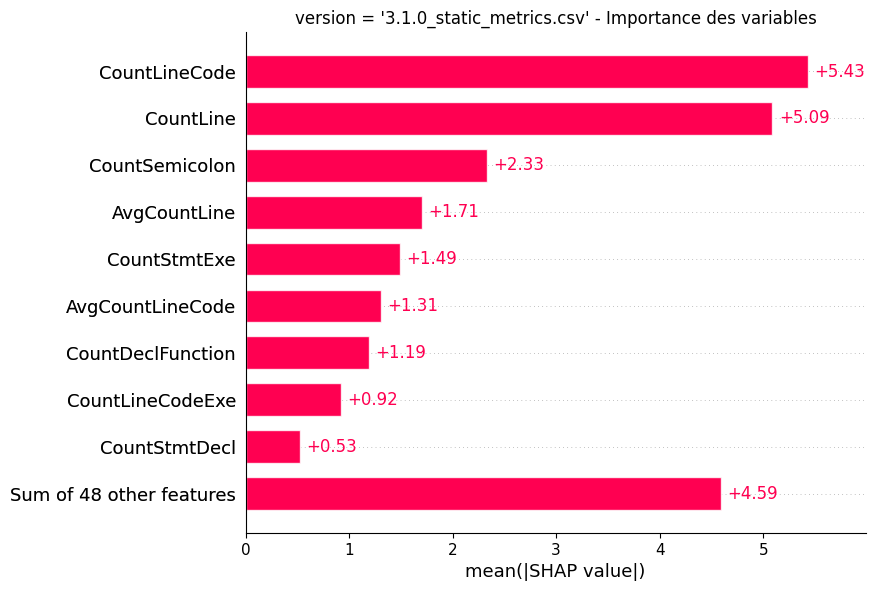

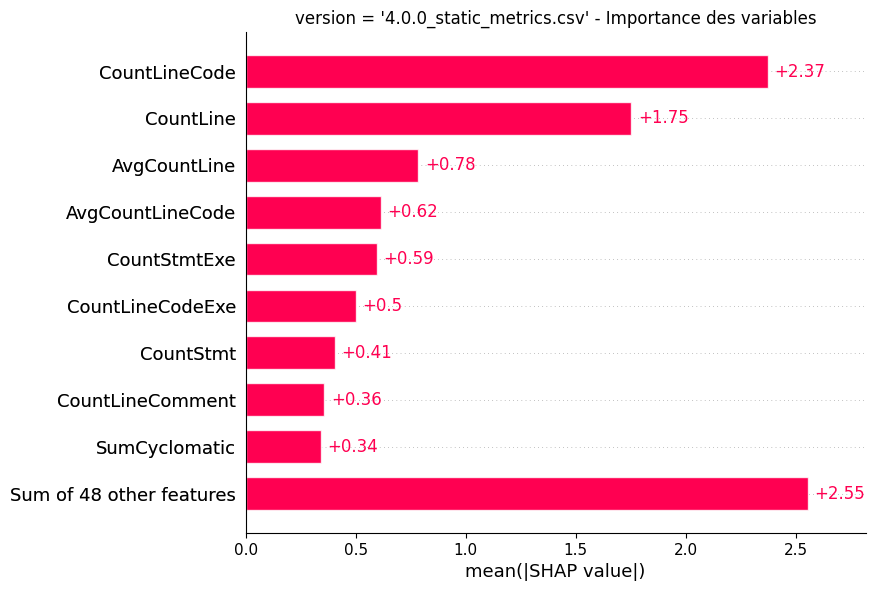

In [32]:
shap_values_versions = {}
for key in logistic_regression_models:
    shap_values = plot_SHAP(logistic_regression_models[key], XY_training_dict[key][0], XY_testing_dict[key][0], key)
    shap_values_versions[key] = shap_values

### 4.3 - Actions to take
#### 4.3.1 Reduce code complexity
`CountLineCode` and `CountStmtExe` are important variables for bug prediction. Indeed, the larger the `CountLineCode` and `CountStmtExe`, the more likely the presence of a bug in the file.

**Solution**: Adopt a modular architecture.

**Example**: HiveConf.java contained 3249 lines of code and 676 statements in release-2.0.0. It could be broken down into several modules, even if these modules exist but have few lines of code (HiveConfUtil.java which contains 8 lines of code and 5 statements).

2.0.0_static_metrics.csv


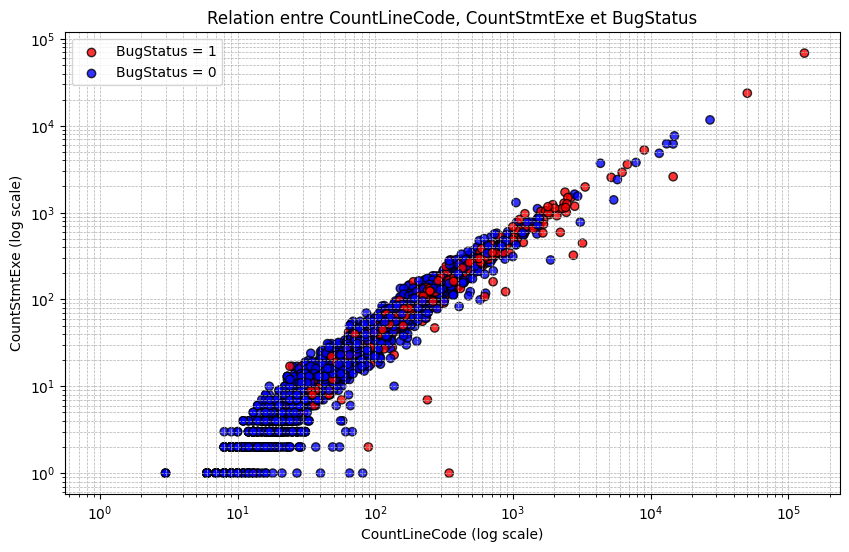

In [33]:
versions: list = list(data_dict.keys())
print(versions[0])
data_2_0_0 = data_dict[versions[0]]

plt.figure(figsize=(10, 6))
colors = data_2_0_0['BugStatus'].map({0: 'blue', 1: 'red'})  # BugStatus=1 en rouge, 0 en bleu
plt.scatter(data_2_0_0['CountLineCode'], data_2_0_0['CountStmtExe'], c=colors, alpha=0.8, edgecolors='k')

plt.xscale('log')
plt.yscale('log')

plt.xlabel('CountLineCode (log scale)')
plt.ylabel('CountStmtExe (log scale)')
plt.title('Relation entre CountLineCode, CountStmtExe et BugStatus')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.scatter([], [], c='red', label='BugStatus = 1', alpha=0.8, edgecolors='k')
plt.scatter([], [], c='blue', label='BugStatus = 0', alpha=0.8, edgecolors='k')
plt.legend()

plt.show()

#### 4.3.2. Promote better code readability
CountLines is an important variable. The larger the CountLines, the more likely the presence of a bug in the file.  Solution: Uniformly format the code (adhere to coding standards), add relevant and concise comments, simplify the code.

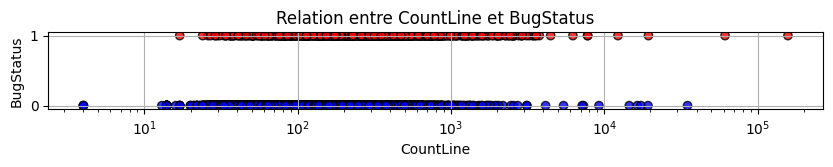

In [34]:
plt.figure(figsize=(10, 1))
colors = data_2_0_0['BugStatus'].map({0: 'blue', 1: 'red'})  # BugStatus=1 en rouge, 0 en bleu
plt.scatter(data_2_0_0['CountLine'], data_2_0_0['BugStatus'], c=colors, alpha=0.8, edgecolors='k')

plt.xscale('log')
plt.xlabel('CountLine')
plt.ylabel('BugStatus')
plt.title('Relation entre CountLine et BugStatus')
plt.grid(True)
plt.show()

#### 4.3.3. Eliminate unnecessary declarations
CountStmtDecl indicates an excess of variables.  Solution: Remove unnecessary variables, methods, and classes, and reuse already declared variables, methods, and classes.

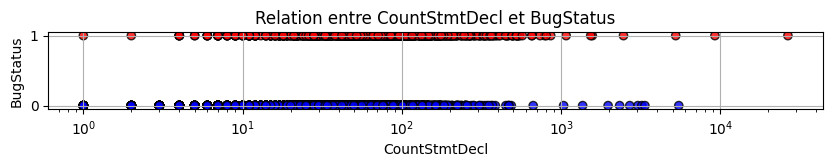

In [35]:
plt.figure(figsize=(10, 1))
colors = data_2_0_0['BugStatus'].map({0: 'blue', 1: 'red'})  # BugStatus=1 en rouge, 0 en bleu
plt.scatter(data_2_0_0['CountStmtDecl'], data_2_0_0['BugStatus'], c=colors, alpha=0.8, edgecolors='k')

plt.xscale('log')
plt.xlabel('CountStmtDecl')
plt.ylabel('BugStatus')
plt.title('Relation entre CountStmtDecl et BugStatus')
plt.grid(True)
plt.show()

#### 4.3.4. Keep logs for each execution
CountStmtExe is an important variable. This indicates that most bugs come from executable statements.  Solution: Adopt logging in all files containing executable statements.  Example: TSetIpAddressProcessor.java contains logging and has no bugs, whereas ASTBuilder.java does not have logging and has a bug.

#### 4.3.5. Develop and automate more tests
Given the importance of `CountStmtExe`, this may require more unit tests.

**Solution**: Improve test coverage by automating them for each commit.

## 5 - Evolution of the most important metrics by version

In [36]:
best_metrics = set()
metrics_values = {}
for key in shap_values_versions.keys():
    version_title = key[:3]
    shap_values = shap_values_versions[key]
    X_test = XY_testing_dict[key][0]
    # Extraire les noms des features depuis X_test
    feature_names = X_test.columns if hasattr(X_test, 'columns') else [f'Feature {i}' for i in range(X_test.shape[1])]
    # Calculer l'importance moyenne absolue des SHAP values pour chaque feature
    shap_mean_importance = np.abs(shap_values.values).mean(axis=0)
    # Trouver les indices des deux features les plus importantes
    top_2_indices = np.argsort(shap_mean_importance)[-3:][::-1]
    # Extraire les noms et les valeurs des deux features les plus importantes
    top_2_features = []
    for i in top_2_indices:
        top_2_features.append((feature_names[i], shap_mean_importance[i]))
        best_metrics.add(feature_names[i])
    metrics_values[version_title] = top_2_features
print(best_metrics)

#

{'AvgCountLineCode', 'CountSemicolon', 'CountLine', 'CountStmt', 'AvgCountLine', 'CountStmtExe', 'CountLineCode'}


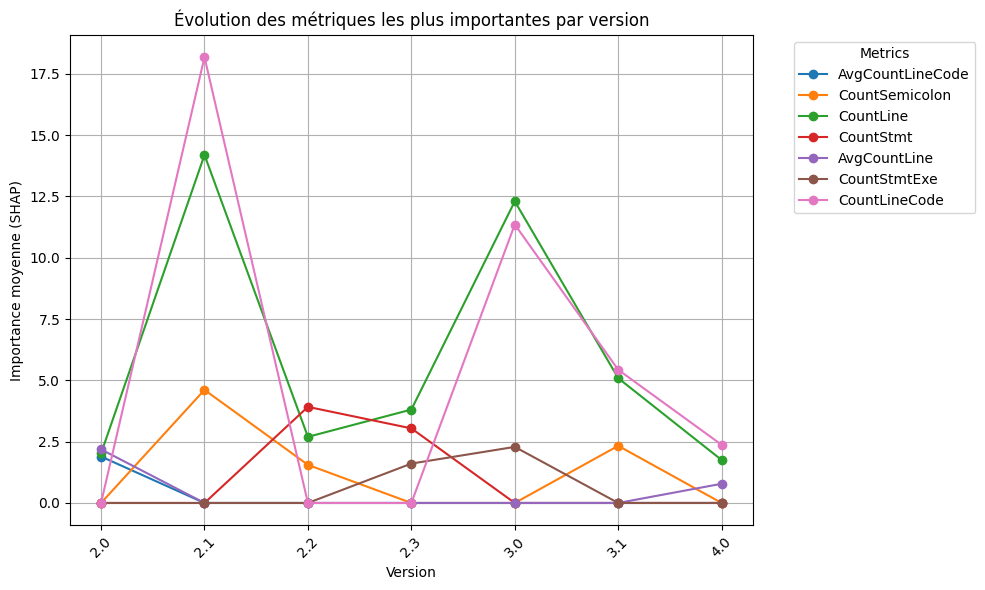

In [37]:
# Initialize a list to store the rows of the DataFrame
rows = []

for version, features in metrics_values.items():
    row = {'version': version}
    for metric_name, metric_value in features:
        row[metric_name] = metric_value
    rows.append(row)  # Ajouter la ligne à la liste

# Convert list to DataFrame
df_metrics = pd.DataFrame(rows)

# Fill missing values with 0 (or NaN as needed)
df_metrics = df_metrics.fillna(0)

# Plot the graph
plt.figure(figsize=(10, 6))
for metric in best_metrics:
    if metric in df_metrics:
        plt.plot(
            df_metrics['version'],
            df_metrics[metric],
            label=metric,
            marker='o'
        )

# AAdd details to the graph
plt.xlabel('Version')
plt.ylabel('Importance moyenne (SHAP)')
plt.title('Évolution des métriques les plus importantes par version')
plt.legend(title='Metrics', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

# Display the graph
plt.show()